# **NYC Taxi Trip Duration Prediction**  

## **Introduction**  
This notebook explores the **NYC Taxi Trip Duration** dataset through **Exploratory Data Analysis (EDA)**, **Feature Engineering**, and **Predictive Modeling**. The goal is to build a regression model to predict trip duration based on various trip-related features.  

### **Key Steps Covered in This Notebook:**  
1. **Data Exploration & Visualization:**  
   - Understanding the dataset structure and distributions.  
   - Visualizing pickup & drop-off locations.  
   - Identifying and handling outliers.  

2. **Feature Engineering:**  
   - Creating new features (e.g., distance calculations, temporal features).  
   - Applying transformations (e.g., log scaling for trip duration and distance).  
   - Encoding categorical variables.  

3. **Model Training:**  
   - Using **Ridge Regression** with a preprocessing pipeline.  
   - Evaluating model performance.  
   
### Data Sampling Notice  
Due to the large size of the NYC trip duration dataset, this exploratory data analysis (EDA) was conducted on a **sample** of the data. This allows for faster analysis while still capturing meaningful insights.  

The sampling process ensures that the distribution of key features remains representative of the full dataset. However, all conclusions drawn from this EDA should be validated on the full dataset before final modeling.


In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [47]:
pd.options.display.max_columns = None  # show ALL columns (or rows) if you want in df.head to avoid ...
pd.options.display.max_rows = 500

In [48]:
# read the data
df_train = pd.read_csv('/train.csv')
df_val = pd.read_csv('/val.csv')
df_test = pd.read_csv('/test.csv')

In [49]:
# First 5 rows of train
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1385950,1,2016-01-08 22:31:12,1,-73.990646,40.751068,-73.995789,40.728146,N,525
1,id1885523,2,2016-01-02 12:36:39,1,-73.982658,40.745071,-74.003258,40.732971,N,799
2,id0892204,2,2016-02-21 00:24:16,1,-73.999481,40.728580,-74.000252,40.718800,N,374
3,id2463973,2,2016-05-08 15:06:34,1,-73.977058,40.759850,-73.949989,40.776001,N,696
4,id1496105,2,2016-05-06 13:54:36,2,-73.977798,40.758221,-73.993080,40.743130,N,703


In [50]:
# number of rows and columns for every data set
df_train.shape , df_val.shape , df_test.shape

((5000, 10), (300, 10), (250, 10))


*  Check to see What are the column data types? date, string, intger, float
*   How many NA elements per column




In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5000 non-null   object 
 1   vendor_id           5000 non-null   int64  
 2   pickup_datetime     5000 non-null   object 
 3   passenger_count     5000 non-null   int64  
 4   pickup_longitude    5000 non-null   float64
 5   pickup_latitude     5000 non-null   float64
 6   dropoff_longitude   5000 non-null   float64
 7   dropoff_latitude    5000 non-null   float64
 8   store_and_fwd_flag  5000 non-null   object 
 9   trip_duration       5000 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 390.8+ KB


Drop the useless columns


In [52]:
for df in [df_train, df_val, df_test]:
    df.drop(['vendor_id'], axis=1, inplace=True)
    df.drop(['id'], axis=1, inplace=True)

Let's See if there are missing values


In [53]:
print(f"numper of missing values of  train is {df_train.isnull().sum().sum()}")
print(f"numper of missing values of  val is {df_val.isnull().sum().sum()}")
print(f"numper of missing values of test is {df_test.isnull().sum().sum()}")

numper of missing values of  train is 0
numper of missing values of  val is 0
numper of missing values of test is 0


In [54]:
# Let's get the frequencies of store_and_fwd_flag column.
df_train.value_counts('store_and_fwd_flag')

,count
store_and_fwd_flag,
N,4964
Y,36


There are two categoreis for store_and_fwd_flag column
*   *Y (Yes) → The trip was stored locally (due to a lost network) and then sent later when connectivity was restored.*

*   *N (No) → The trip was recorded and sent to the server immediately.*

In [55]:
df_train.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.65440,-73.973659,40.751530,-73.972305,40.752438,969.608200
std,1.29325,0.057585,0.042378,0.056861,0.045901,3616.929016
min,1.00000,-74.177292,40.619514,-74.183403,40.575306,2.000000
25%,1.00000,-73.991638,40.737639,-73.991266,40.735735,392.000000
50%,1.00000,-73.981895,40.754238,-73.979771,40.754862,656.000000
75%,2.00000,-73.967855,40.768205,-73.962240,40.770319,1066.000000
max,6.00000,-70.851616,43.017578,-70.851616,43.017578,86329.000000


### Summary Statistics & Key Insights

From the descriptive statistics of our dataset, we observe:

- **Passenger Count**:  
  - Most trips are for a **single passenger (median = 1)**, with a few group rides (max = 6).  

- **Pickup & Dropoff Coordinates**:  
  - Most trips are **concentrated in NYC** (small standard deviations).  
  - Some extreme values may be **outliers or GPS errors**.  
  - The **close mean values for pickup and dropoff coordinates** imply that many trips are **short, local journeys within the same neighborhood or nearby areas**.  
  - The **minimum and maximum values for longitudes and latitudes show a wider range**, indicating that while most trips are concentrated in a specific area, some **outlier trips extend beyond typical NYC boundaries** (e.g., outer boroughs or incorrect GPS data).  

- **Trip Duration**:  
  - The **average trip lasts ~16 minutes**, but the distribution is skewed by long-duration trips.  
  - The **maximum trip duration (~24 hours) is unrealistic**, indicating possible outliers.  
  - The values in **trip duration are large**, so applying a **log transformation** can help **normalize the distribution and improve model performance**.  


In [56]:
# apply log to trip_duration column
for df in [df_train, df_val, df_test]:
  df['log_trip_duration'] = np.log1p(df['trip_duration'])
df_train['log_trip_duration'].head()

,log_trip_duration
0,6.265301
1,6.684612
2,5.926926
3,6.546785
4,6.556778


### **Trip Duration Distribution (Before & After Log Transformation)**  

#### **Observations from the Original Distribution (Left Plot)**
- The `trip_duration` variable is **highly right-skewed**, indicating that most trips are short, but there are some extreme long-duration trips.
- A large concentration of trips falls within a **small range**, while a few outliers have significantly longer durations.
- The presence of **long-duration trips** suggests possible **outliers** or data irregularities (e.g., taxi left running, recording errors).

#### **Observations from the Log-Transformed Distribution (Right Plot)**
- Applying a **log transformation (`log1p(trip_duration)`)** makes the distribution **closer to normal**.
- The transformed distribution is **smoother and more symmetric**, which is beneficial for machine learning models.
- This transformation reduces the effect of outliers and makes patterns in the data more evident.

#### **Key Takeaways**
- **Why is this transformation useful?** Many machine learning models perform better when the target variable follows a normal distribution.
- **Next Steps:**
  - Consider **removing extreme outliers** (e.g., trips with unrealistically long durations).
  - Use the **log-transformed `trip_duration`** as the target variable in regression models for better prediction performance.


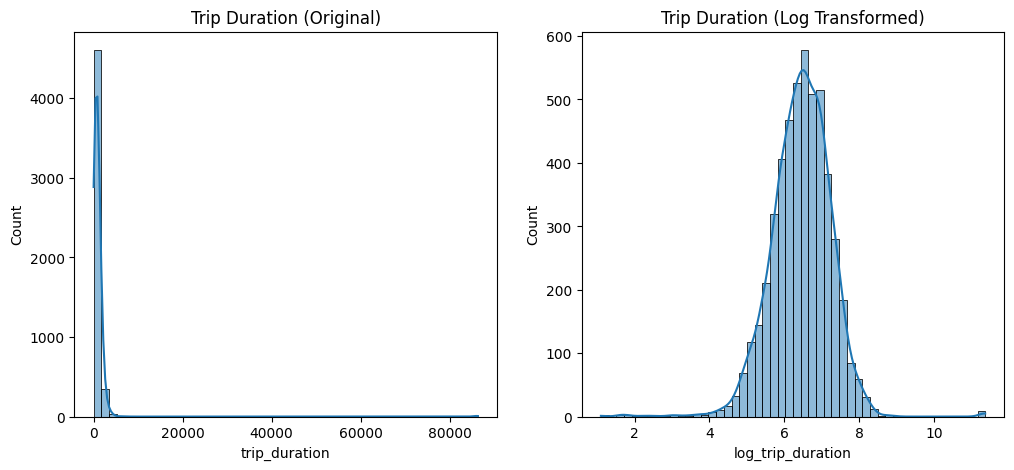

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_train['trip_duration'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Trip Duration (Original)')

sns.histplot(df_train['log_trip_duration'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Trip Duration (Log Transformed)')
plt.show()

### Feature Engineering from pickup_datetime Column  

To better understand patterns in trip duration, we extracted additional time-based features from the original **pickup_datetime** column:  

- **`day_of_week`**: Represents the day of the week (Monday to Sunday). This helps analyze how trip durations vary between weekdays and weekends.  
- **`hour`**: Extracts the hour of the day (0–23). This captures daily patterns, such as peak hours vs. off-peak hours.  
- **`month`**: Identifies the month of the trip, which can highlight seasonal trends in trip durations.  
- **`day_of_year`**: Provides the day number within the year (1–365/366). This can be useful for analyzing trends over the entire year, considering holidays and weather effects.  

These time-based features help uncover **daily, weekly, and seasonal variations** in trip duration, which can be valuable for further analysis and modeling.



In [58]:
# Transform the data type to datetime to extract the new columns
for df in [df_train, df_val, df_test]:
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df_train['pickup_datetime'].head()

,pickup_datetime
0,2016-01-08 22:31:12
1,2016-01-02 12:36:39
2,2016-02-21 00:24:16
3,2016-05-08 15:06:34
4,2016-05-06 13:54:36


In [59]:
# Function for extraing the new columns form 'pickup_datetime'
def datetime_columns(df_train, df_val, df_test, date_col, columns_names, columns_type):
    for name, dtype in zip(columns_names, columns_type):
        df_train[name] = getattr(df_train[date_col].dt, dtype)
        df_val[name] = getattr(df_val[date_col].dt, dtype)
        df_test[name] = getattr(df_test[date_col].dt, dtype)
    return df_train, df_val, df_test

In [60]:
columns_names = ["day_of_week", "hour", "month", "day_of_year"]
columns_type = ["dayofweek", "hour", "month", "dayofyear"]
df_train, df_val, df_test = \
    datetime_columns(df_train, df_val, df_test, 'pickup_datetime', columns_names, columns_type)


### Analysis & Key Takeaways from the Visualizations

#### 1️⃣ Day of the Week (Top Left)
- The trip duration is lowest on Sunday (0), increases throughout the week, peaks on Thursday (3-4), and then drops significantly on Friday & Saturday (5-6).
- Possible Interpretation:
  - Longer trips on weekdays (Monday–Thursday) could be work-related trips.
  - Shorter trips on weekends likely indicate leisure trips, shorter commutes, or higher traffic congestion slowing down trips.

#### 2️⃣ Hour of the Day (Top Right)
- Morning dip around 6 AM with a steady increase after 6 AM, peaking at 3 PM-4 PM. Another dip in the evening but remains relatively high.
- Possible Interpretation:
  - The morning rush hour effect is not as strong here.
  - Afternoon peak (3 PM-4 PM) could indicate school dismissals or business travel.
  - Evening hours remain steady, indicating steady demand for transportation.

#### 3️⃣ Month (Bottom Left)
- There’s a gradual increase in trip duration as months progress.
- Possible Interpretation:
  - Seasonal effects might be at play (e.g., winter months could have slower travel due to weather).
  - More tourists or long-distance trips during summer months.

#### 4️⃣ Day of the Year (Bottom Right)
- A highly fluctuating pattern with no clear trend.
- Possible Interpretation:
  - Trip duration varies on a daily basis, likely influenced by holidays, special events, and weather.
  - Large spikes might correspond to specific events (e.g., New Year, Christmas, etc.).

### Final Thoughts
1. Weekdays tend to have longer trips than weekends.
2. Afternoon trips are generally longer than early mornings.
3. Trip duration gradually increases across months.
4. Daily trip duration fluctuates heavily, indicating short-term external factors (events, holidays, etc.).


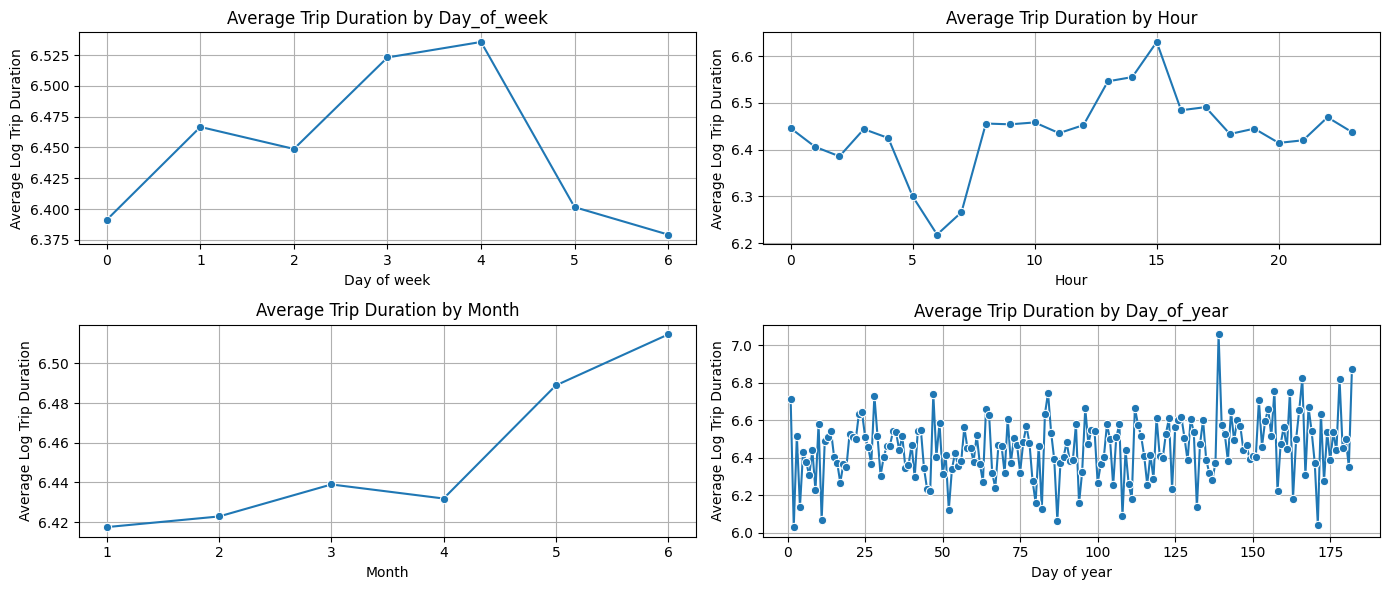

In [61]:
columns_names = ["day_of_week", "hour", "month", "day_of_year"]

plt.figure(figsize=(14, 6))  # Set figure size

for i, col in enumerate(columns_names, 1):
    df_grouped = df_train.groupby(col)['log_trip_duration'].mean().reset_index()

    plt.subplot(2, 2, i)  # Arrange plots in a 2x2 grid
    sns.lineplot(data=df_grouped, x=col, y='log_trip_duration', marker='o')

    plt.title(f'Average Trip Duration by {col.capitalize()}')
    plt.xlabel(col.replace('_', ' ').capitalize())
    plt.ylabel('Average Log Trip Duration')
    plt.grid(True)

plt.tight_layout()  # Adjust spacing
plt.show()



# **Analysis of Pickup and Dropoff Location Density**

## **Key Observations:**
1. **Pickup Density (Left Plot - Red)**
   - The highest density of pickups occurs around **latitude ~40.75 and longitude ~-74.00**.
   - This suggests that most rides originate from a central, possibly commercial or transportation hub.
   - A secondary, smaller cluster is visible around **longitude ~-73.85**, likely an airport or another high-demand location.

2. **Dropoff Density (Right Plot - Blue)**
   - Dropoffs also peak in a similar area near **latitude ~40.75, longitude ~-74.00**, but the density is slightly more dispersed.
   - This indicates that passengers are being dropped off in a slightly wider area compared to where they are picked up.
   - The secondary cluster is much less prominent in dropoffs, implying that the location near **longitude ~-73.85** might be a one-way trip destination, such as an airport.

3. **Comparison Between Pickup and Dropoff Trends**
   - **Pickup locations are more concentrated**, indicating a centralized starting point (e.g., business district, major transit hub).
   - **Dropoffs are more dispersed**, suggesting passengers travel to diverse locations, likely residential or varied destinations.


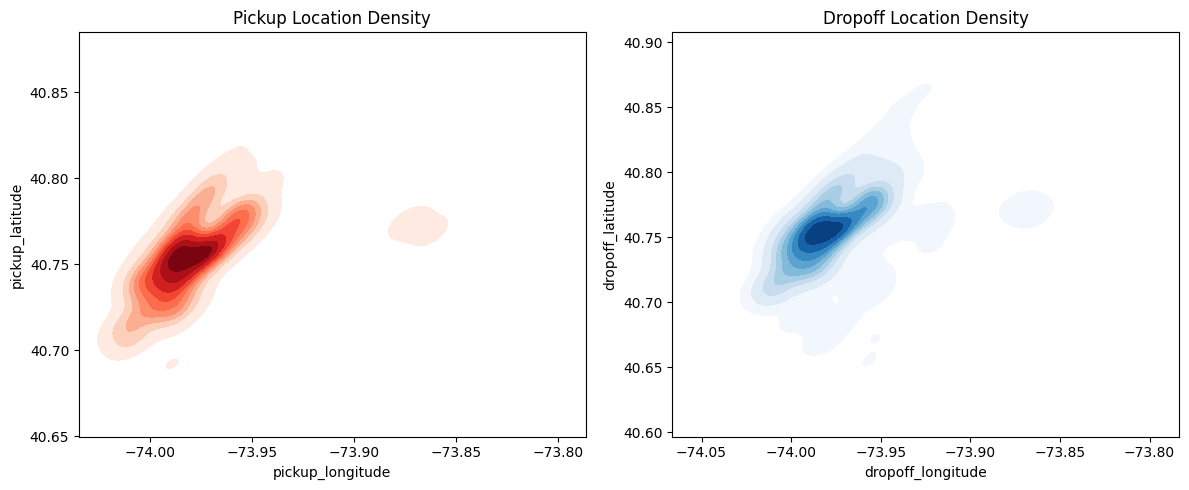

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1-row, 2-column subplot

# Pickup Location Density
sns.kdeplot(
    x=df_train['pickup_longitude'],
    y=df_train['pickup_latitude'],
    cmap="Reds", shade=True, ax=axes[0]
)
axes[0].set_title('Pickup Location Density')

# Dropoff Location Density
sns.kdeplot(
    x=df_train['dropoff_longitude'],
    y=df_train['dropoff_latitude'],
    cmap="Blues", shade=True, ax=axes[1]
)
axes[1].set_title('Dropoff Location Density')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### **Feature Engineering: Distance Calculation**

To enhance our analysis of trip durations, we computed the **Haversine Distance**, which measures the great-circle distance between two geographic points. This provides a more accurate representation of real-world travel distances compared to a simple straight-line measure.

This feature helps in understanding how trip duration correlates with travel distance and can improve predictive modeling.


In [63]:
# calculate haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

In [64]:
# Constants to Convert Latitude/Longitude to Kilometers
LAT_TO_KM = 111  # 1 degree latitude ≈ 111 km
LON_TO_KM = 111  # 1 degree longitude ≈ 111 km at the equator

def add_distance_columns(df_train, df_val, df_test):
    """Compute Manhattan, Euclidean, and Haversine distances (all in KM)."""
    for df in [df_train, df_val, df_test]:
        # Convert latitude & longitude differences to KM
        delta_lat_km = (df["dropoff_latitude"] - df["pickup_latitude"]) * LAT_TO_KM
        delta_lon_km = (df["dropoff_longitude"] - df["pickup_longitude"]) * LON_TO_KM
        # Haversine Distance (more accurate for real-world travel)
        df['haversine_distance'] = df.apply(
            lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'],
                                           row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    return df_train, df_val, df_test

In [65]:
# generate new column "haversine_distance" from latitude and longitude
df_train, df_val, df_test = add_distance_columns(df_train, df_val, df_test)

### **Applying Log Transformation to Distance Feature**

To handle the skewness in the distance-related feature, we apply a **log transformation** to the **Haversine Distance**.

#### **Why Apply Log Transformation?**  
- Distance values have a **right-skewed distribution**, meaning some trips cover significantly longer distances.  
- Log transformation helps **normalize the distribution**, reducing the impact of extreme values and improving model performance.  
- Many machine learning models perform better when features are **closer to a normal distribution**.  


In [66]:
for df in [df_train, df_val, df_test]:
    df['haversine_distance'] = np.log1p(df['haversine_distance'])  # log1p(x) = log(1 + x), avoids issues with zero values

### **Distance vs. Trip Duration Analysis**

#### **Objective:**  
- To analyze how the Haversine distance correlates with trip duration.

#### **Findings:**  
- Haversine distance shows a **strong positive correlation** with trip duration.  
- The relationship appears **approximately linear** in the log-transformed trip duration.  
- Some variability is present, which could be influenced by traffic, road conditions, or other unmeasured factors.  


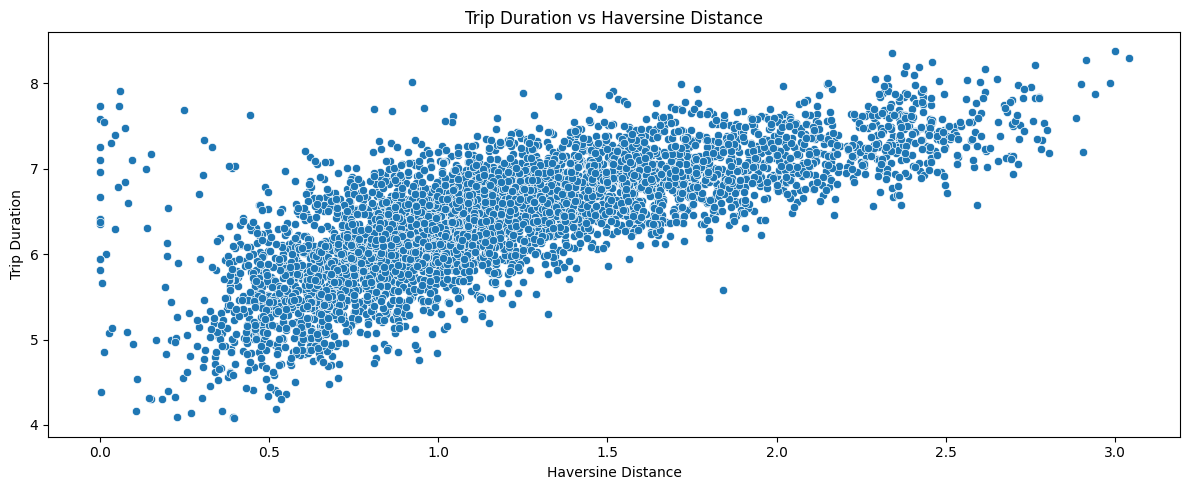

In [82]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Create the scatter plot on the axis
sns.scatterplot(x=df_train['haversine_distance'], y=df_train['log_trip_duration'], ax=ax)

# Set titles and labels using the correct object
ax.set_title('Trip Duration vs Haversine Distance')
ax.set_xlabel('Haversine Distance')
ax.set_ylabel('Trip Duration')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### **Bearing Angle Feature**

To better understand the **direction of travel**, we generated a new feature called **bearing** using the pickup and dropoff latitude/longitude coordinates.

- **What is Bearing?**  
  - The **bearing angle** represents the **direction of travel** between the pickup and dropoff locations in degrees (0°–360°).  
  - It helps capture the **route orientation**, which may impact trip duration.  

- **Why is this Useful?**  
  - Different trip directions may have different traffic patterns and travel times.  
  - Certain routes (e.g., north-south vs. east-west) may correlate with trip duration.  

- **Feature Engineering Steps:**  
  - **Calculated the bearing angle** using the haversine formula.  
  - **Derived sine and cosine transformations** (`bearing_sin`, `bearing_cos`) to avoid circularity issues in models.  


In [68]:
# Function for calculating the bearing
def calculate_bearing(lat1, lon1, lat2, lon2):
    delta_lon = np.radians(lon2 - lon1)
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)

    return np.degrees(np.arctan2(x, y))

In [69]:
def generate_bearing_col(df_train, df_val, df_test):
    for df in [df_train, df_val, df_test]:
        df["bearing"] = \
            calculate_bearing(df["pickup_latitude"], df["pickup_longitude"], df["dropoff_latitude"],
                              df["dropoff_longitude"])
        df["bearing_sin"] = np.sin(np.radians(df["bearing"]))
        df["bearing_cos"] = np.cos(np.radians(df["bearing"]))

    return df_train, df_val, df_test

In [70]:
# generate new columns bearing,bearing_sin,bearing_cos from latitude and longitude
df_train, df_val, df_test = generate_bearing_col(df_train, df_val, df_test)

Devide data into categorical columns and numerical columns

In [71]:
# divide categorical and numerical columns
categorical_cols = ['passenger_count', 'store_and_fwd_flag','day_of_week', 'hour', 'month', 'day_of_year']

num_cols = ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'
    , 'haversine_distance', 'bearing','bearing_cos','bearing_sin']


# **Feature Correlation Analysis**

## **Key Observations:**
1. **High Correlation Among Distance Features:**
   - `haversine_distance` is a key feature representing trip distance.

2. **Latitude and Longitude Correlations:**
   - `pickup_longitude` and `dropoff_longitude` are moderately correlated (**0.70**).
   - `pickup_latitude` and `dropoff_latitude` are also correlated (**0.74**).
   - This makes sense since trips tend to start and end in nearby locations.

3. **Bearing and Its Components:**
   - `bearing_sin` and `bearing_cos` are correlated with `bearing`, as expected.
   - `bearing_sin` and `bearing_cos` are weakly correlated with distance features, suggesting they might provide additional directional information.

4. **Low Correlation Between Pickup/Dropoff Coordinates and Distance Metric:**
   - `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude` have **low correlation with `haversine_distance`** (~0.2).
   - This means that `haversine_distance` captures different information than raw coordinates, making it a valuable feature.


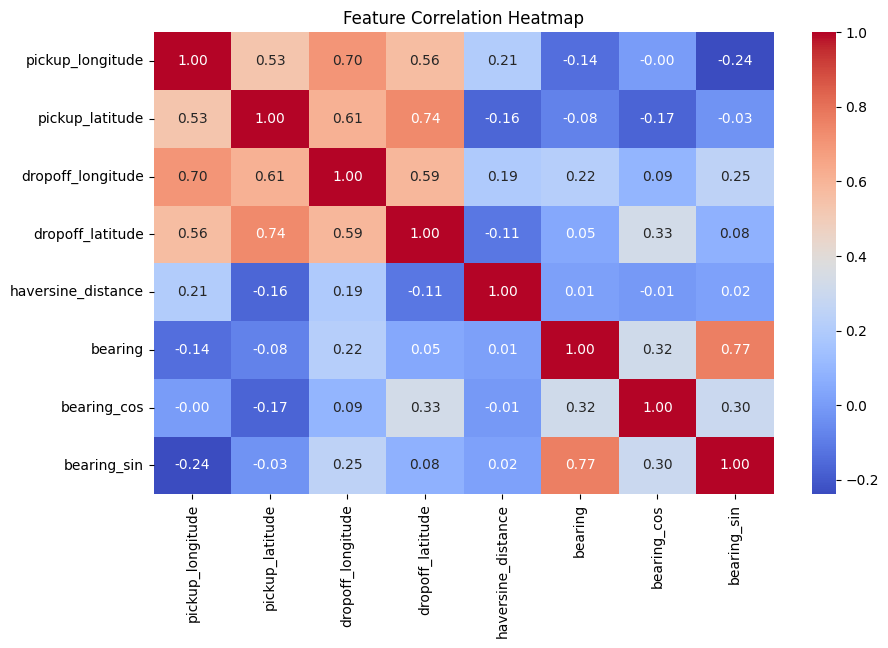

In [72]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


### Removing Outliers from Numerical Columns  

Outliers can distort statistical analysis and negatively impact model performance.  
To handle this, we remove extreme values using **Z-score filtering**:  

- Compute the **Z-score** for numerical columns.  
- Identify **outliers** as values where **|Z-score| > 3** (i.e., more than 3 standard deviations from the mean).  
- Remove these outliers to ensure a **cleaner dataset** for model training.  

This step helps **reduce noise** and improve the robustness of our analysis and predictions. 🚀


Histogram for indicating the outliers in longitude and latitude


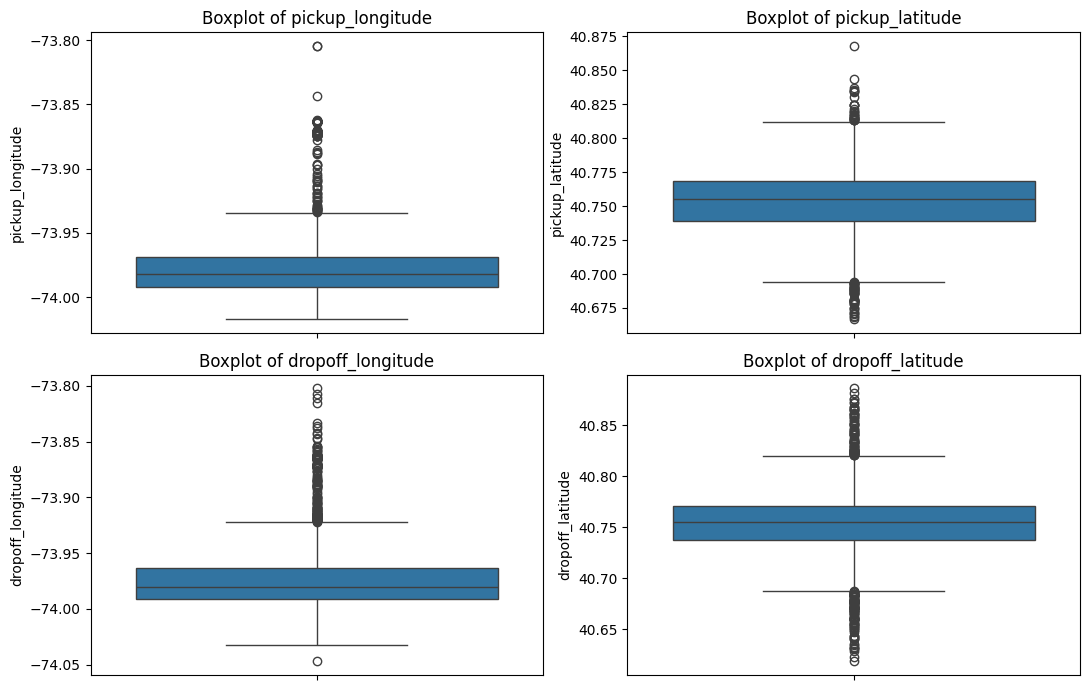

In [81]:
# Plot boxplots for each longitude and latitude
lon_lat_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
plt.figure(figsize=(11, 7))
for i, col in enumerate(lon_lat_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_train[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

Histogram for indicating the outliers in distance


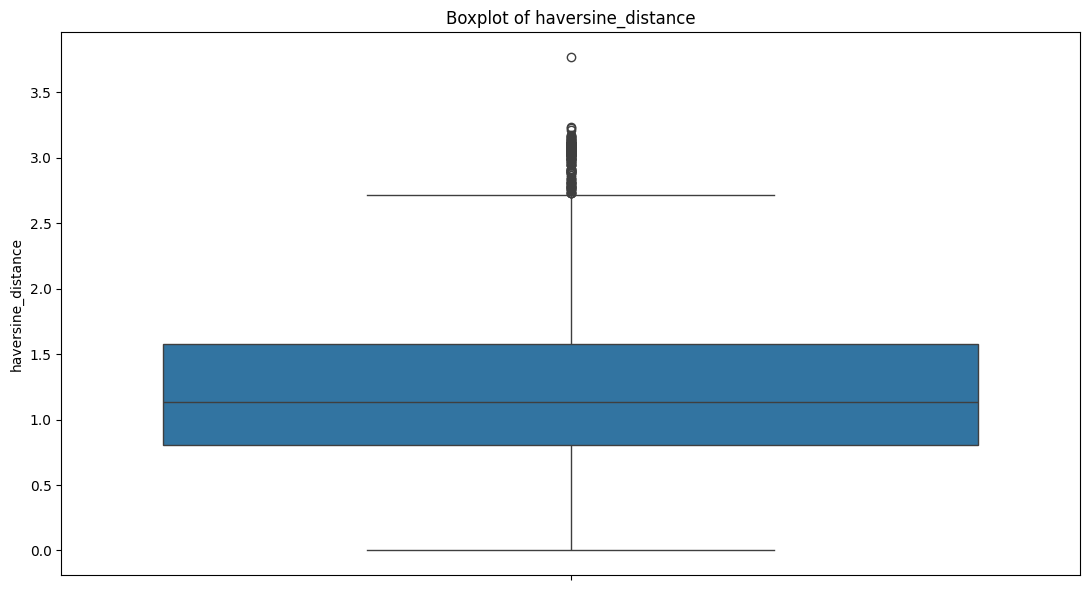

In [74]:
# Plot boxplots for each distance
col = 'haversine_distance'
plt.figure(figsize=(11, 6))
sns.boxplot(y=df_train[col])
plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

### Outlier Analysis & Insights  

From the visualizations, we observe:  
- Some **extreme values** in numerical columns, especially in **trip duration and distance metric**.  
- A **right-skewed distribution** in trip duration, confirming the presence of very long trips.  
- Some latitude/longitude values that might indicate **GPS errors or incorrect data entries**.  


In [75]:
# Function for removing outliers
def remove_outliers(df_train, df_val, df_test, num_colss):
    cleaned_dfs = []
    num_cols=num_colss.copy()
    num_cols.append("log_trip_duration")
    for df in [df_train, df_val, df_test]:
        # Compute Z-scores for numerical columns
        z_scores = df[num_cols].apply(zscore)

        # Define a threshold (e.g., |z| > 3 is considered an outlier)
        threshold = 3

        # Create a boolean mask where True indicates an outlier
        outlier_mask = (z_scores.abs() > threshold).any(axis=1)

        # Remove outliers and reset index
        df_cleaned = df[~outlier_mask].reset_index(drop=True)

        cleaned_dfs.append(df_cleaned)

    return cleaned_dfs  # Returns the cleaned versions of df_train, df_val, df_test

In [76]:
# Remove outliers for numerical columns
df_train, df_val, df_test=remove_outliers(df_train, df_val, df_test, num_cols)

### Feature Transformation & Engineering  

To prepare our dataset for modeling, we apply appropriate transformations to both **categorical** and **numerical** features:  

- **Categorical Features** (`passenger_count`, `store_and_fwd_flag`, `day_of_week`, `hour`, `month`, `day_of_year`)  
  - **One-Hot Encoding (OHE)** is used to convert categorical variables into numerical format.  
  - Unknown categories in validation/test sets will be **ignored** to prevent errors.  

- **Numerical Features** (`pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `haversine_distance`, `bearing`, `bearing_cos`, `bearing_sin`)  
  - We apply **Polynomial Feature Engineering (degree=3)** to capture complex interactions between features.  
  - **Standard Scaling** ensures all numerical values are on a comparable scale, improving model stability.  

💡 **Why This Matters?**  
- OHE helps models understand categorical variables better.  
- Polynomial features can enhance model performance by capturing non-linear relationships.  
- Scaling ensures that distance-based models (e.g., k-NN, regression) work effectively.  


In [77]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    # One-hot encoding for categorical
    ('poly', Pipeline([  # Apply PolynomialFeatures + Scaling to numerical
        ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaling', StandardScaler())
    ]), num_cols)
], remainder='passthrough')

### Model Training  

For training the model, we set up a **pipeline** that consists of:  

1. **Feature Transformation** (`column_transformer`):  
   - **Categorical Features**: One-Hot Encoding (OHE) is applied to handle categorical variables.  
   - **Numerical Features**: Polynomial features (degree = 3) are generated, followed by standardization.  

2. **Regression Model**:  
   - We use **Ridge Regression** with **alpha = 1** to prevent overfitting by adding L2 regularization.  

The model is trained on the transformed features using `df_train`, and the target variable is **trip duration**.


In [78]:
# Model Training
pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', Ridge(alpha=1))
])
train_feat = categorical_cols + num_cols
model = pipeline.fit(df_train[train_feat], df_train['log_trip_duration'])

In [79]:
# Functuon for evaluating the model
def evaluate(x_data, y_data,model,name):
    y_data_pred = model.predict(x_data)
    print(f"{name} R2 Score: {r2_score(y_data, y_data_pred):.4f}")
    print(f"{name} MSE: , {mean_squared_error(y_data, y_data_pred)}")
    # return y_data_pred

In [80]:
evaluate(df_train[train_feat], df_train['log_trip_duration'], model, 'train')

train R2 Score: 0.6907
train MSE: , 0.14956336039482548
